In [3]:
import torch
import numpy as np
import os
from data_handling import img2tensor
from UNetV2 import UNetV2
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn.functional as F
from PIL import Image


def img2tensor(img, dtype: np.dtype = np.float32):
    img = np.transpose(img, (2, 0, 1))
    tensor = torch.from_numpy(img.astype(dtype, copy=False))
    return tensor

train = True

path_to_models = r'C:\Users\USER\Desktop\UNIVERSIDAD\MÁSTER AERONÁUTICA - UC3M\SEGUNDO\TRABAJO DE FIN DE MÁSTER\Development\Nets\Trained'
weights = torch.load(os.path.join(path_to_models, 'UNETv2_SLPositives_0804_20epoch.pth'))
model = UNetV2(in_channels=3, first_out_channels=64, exit_channels=1, padding=0, levels=3)
model.load_state_dict(weights)
model.eval()
net = model

fig, axs = plt.subplots(3, 4, figsize=(15, 8))

# Take a set of 5 random images with contrails to visualize the network performance
images_path = r'D:\GOES-16 Dataset\SingleFrame_PNG\train\images' if train else r'D:\GOES-16 Dataset\SingleFrame_PNG\validation\images'
positives_fnames = [filename.split("\\")[3] for filename in np.load(r'C:\Users\USER\Desktop\UNIVERSIDAD\MÁSTER AERONÁUTICA - UC3M\SEGUNDO\TRABAJO DE FIN DE MÁSTER\Development\Inspection\positive_train.npy' if train else r'C:\Users\USER\Desktop\UNIVERSIDAD\MÁSTER AERONÁUTICA - UC3M\SEGUNDO\TRABAJO DE FIN DE MÁSTER\Development\Inspection\positive_validation.npy')]
positives_fnames = np.random.choice(positives_fnames, size=3, replace=False)
# Locate their corresponding labels
labels_path = r'D:\GOES-16 Dataset\SingleFrame_PNG\train\soft_label' if train else r'D:\GOES-16 Dataset\SingleFrame_PNG\validation\ground_truth'

for i, fname in enumerate(positives_fnames):
     img_path = os.path.join(images_path, fname + '.png')
     lbl_path = os.path.join(labels_path, fname + '.npy')
     image = np.array(Image.open(img_path))
     input_tensor = img2tensor(image/255)
     input_tensor = input_tensor.unsqueeze(0)
     input_tensor = F.pad(input_tensor,(94,94,94,94), mode='reflect')
     outputs = torch.sigmoid(net(input_tensor)).view(1,256,256)
     outputs_binary = (outputs > 0.5).float()
     outputs_cmap = outputs.cpu().detach().numpy()
     labels = img2tensor(np.load(lbl_path))
     
     axs[i][0].imshow(image)          
     axs[i][1].imshow(labels[0,:,:], cmap='gray_r')
     axs[i][1].set_title(fname) 
     im = axs[i][2].imshow(outputs_cmap[0,:,:], cmap='turbo')
     fig.colorbar(im, ax=axs[i][2])  # Add colorbar to the third column
     axs[i][3].imshow(outputs_binary[0,:,:], cmap='gray_r')


plt.tight_layout()  
plt.show() 

ModuleNotFoundError: No module named 'UNetV2'

In [3]:
import torch
import torch.nn as nn
import numpy as np
import os
from data_handling import img2tensor
from UNet import UNet
from data_handling import ContrailsDataset
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn.functional as F

def validate(net, usage, test_batch_size=50, threshold=0.5, example=4, print_percentages=False):    

     testset = ContrailsDataset(path=r'D:\GOES-16 Dataset\SingleFrame_PNG', use=usage)
     testloader = torch.utils.data.DataLoader(testset,batch_size=test_batch_size, shuffle=True, num_workers=0)

     criterion = nn.BCEWithLogitsLoss()

     # Positive pixels labelled as positive
     correct_positive = 0
     # Negative pixels labelled as negative
     correct_negative = 0
     # Positive pixels labelled as negative
     incorrect_positive = 0
     # Negative pixels labelled as positive
     incorrect_negative = 0

     total_positive = 0
     total_negative = 0

     running_loss = 0

     with torch.no_grad():
          for i, data in enumerate(testloader):
               images, labels = data
               images = F.pad(images,(11,11,11,11), mode='reflect')
               outputs = torch.sigmoid(net(images)).view(-1,1,256,256)
               binary_outputs = (outputs > threshold).float()

               loss = criterion(outputs, labels)
               running_loss += loss.item()

               total_positive += torch.sum(labels == 1).item()
               total_negative += torch.sum(labels == 0).item()

               correct_positive += torch.sum((binary_outputs == 1) & (labels == 1)).item()
               correct_negative += torch.sum((binary_outputs == 0) & (labels == 0)).item()
               incorrect_positive += torch.sum((binary_outputs == 0) & (labels == 1)).item()
               incorrect_negative += torch.sum((binary_outputs == 1) & (labels == 0)).item()

               print(f'Processing batch {i+1}/{len(testloader)}', end='\r')

     correct_positive_percentage = correct_positive/total_positive*100
     incorrect_positive_percentage = incorrect_positive/total_positive*100
     correct_negative_percentage = correct_negative/total_negative*100
     incorrect_negative_percentage = incorrect_negative/total_negative*100

     if print_percentages:
          print(f'\n Positive pixels: Correct={correct_positive_percentage: .2f}% vs. Incorrect ={incorrect_positive_percentage: .2f}%.', end='\n')
          print(f'Negative pixels: Correct={correct_negative_percentage: .2f}% vs. Incorrect ={incorrect_negative_percentage: .2f}%.', end='\n')

     return running_loss/len(testloader)

net = UNet(in_channels=3, first_out_channels=64, exit_channels=1, padding=0, levels=2)
pretrained_model_path = r"C:\Users\USER\Desktop\UNIVERSIDAD\MÁSTER AERONÁUTICA - UC3M\SEGUNDO\TRABAJO DE FIN DE MÁSTER\Development\Nets\Trained\UNET_SLPositives_2203_4epoch_GA.pth"
pretrained_dict = torch.load(pretrained_model_path)
net.load_state_dict(pretrained_dict)
net.eval()

val_loss = validate(net, example=False, usage='cross-validate')
print(f'\n{val_loss}')


Processing batch 12/12
0.7214866379896799


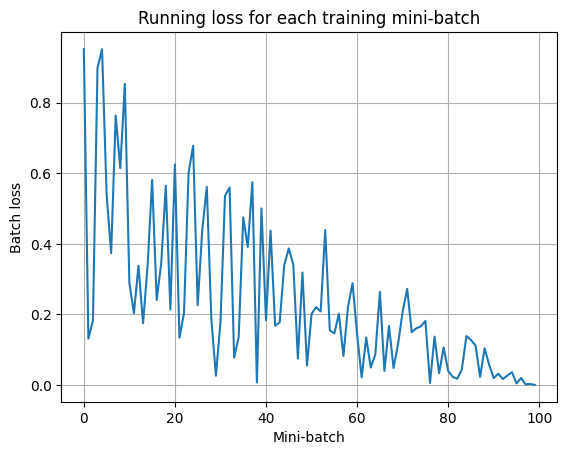

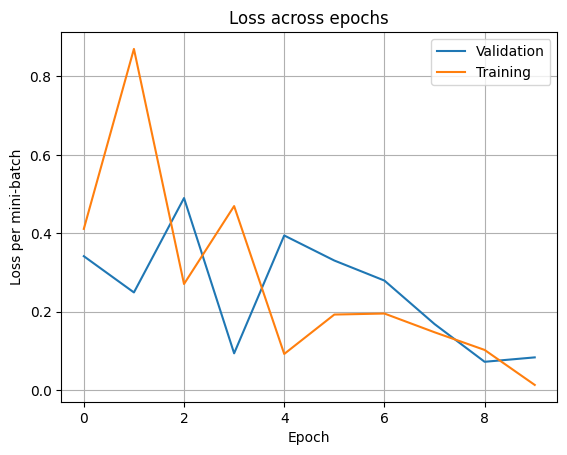

In [6]:
import numpy as np
import matplotlib.pyplot as plt


loss_evolution = []
val_evolution = []
train_evolution = []

for i in range(100):
     loss_evolution.append(np.random.rand(1)*(100-i)/100)
     
for i in range(10):     
     val_evolution.append(np.random.rand(1)*(10-i)/10)
     train_evolution.append(np.random.rand(1)*(10-i)/10)

def generate_loss_plots(loss_evolution, val_evolution, train_evolution):
     plt.plot(range(len(loss_evolution)), loss_evolution)
     plt.xlabel('Mini-batch')
     plt.ylabel('Batch loss')
     plt.title('Running loss for each training mini-batch')
     plt.grid(True)
     plt.show()

     plt.plot(range(len(val_evolution)), val_evolution, label='Validation')  
     plt.plot(range(len(train_evolution)), train_evolution, label='Training')  
     plt.xlabel('Epoch')
     plt.ylabel('Loss per mini-batch')
     plt.legend()
     plt.title('Loss across epochs')
     plt.grid(True)
     plt.show()

generate_loss_plots(loss_evolution, val_evolution, train_evolution)